# Using Advanced Regression Techniques to Predict Housing Prices

I learned a great amount from this assignment. I'd first like to give credit and thank the following author's notebooks for helping guide me through this project

 Suyash Lakhani https://www.kaggle.com/suyashlakhani/house-price-advanced-regression-easy-solution/output
 
 dirty_noob https://www.kaggle.com/punugoti/house-price-prediction-top-20/notebook
 
 Ss Lim https://www.kaggle.com/gsslim/feature-engineering-for-house-price-v3-top-6/notebook#Step-3---Create-Features
 
 MohammedSohailAbrar 3 https://www.kaggle.com/mohammedsohailabrar/house-price-predictions-competition/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from sklearn.linear_model import LinearRegression, Lasso , ElasticNet ,Ridge
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV,RandomizedSearchCV


In [2]:
train = pd.read_csv("house_train.csv")
test = pd.read_csv("test.csv")


Merge train and test to prevent having to do it twice 

In [3]:
total_data = pd.concat([train.drop('SalePrice',axis=1),test],axis=0,ignore_index = True)
total_data.drop('Id',axis=1,inplace=True)

print(total_data.shape)


(2919, 79)


## EDA

Overview of data

In [4]:
pd.set_option("display.max_columns", None)
print(train.head())
print(train.shape)
print(train.describe())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

View of null records

<AxesSubplot:>

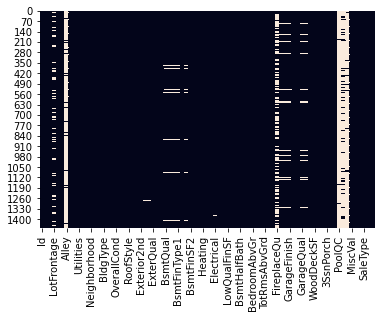

In [5]:
sns.heatmap(train.isnull(), cbar=False)


In [7]:
train.isnull().sum()[train.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

drop these columns due to the enormous amount of outliers

In [7]:
total_data = total_data.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1)

In [8]:

nominal = ['OverallQual','TotRmsAbvGrd','GarageCars','OverallCond','MSSubClass', 'BsmtFullBath','BsmtHalfBath',
          'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr', 'Fireplaces']
y = train['SalePrice']


In [9]:
object_type = total_data.dtypes[total_data.dtypes == 'object'].index

C:\Users\19046\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

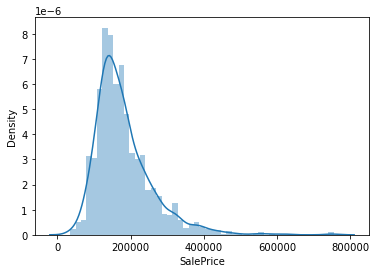

In [10]:
sns.distplot(y)


<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

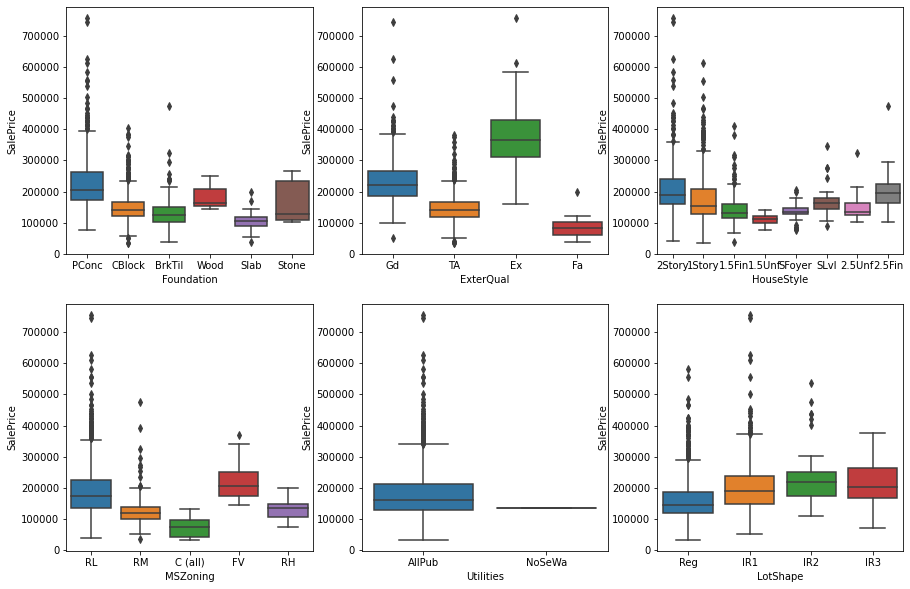

In [11]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,3,1)
sns.boxplot(data = train, x = 'Foundation', y = 'SalePrice', ax=ax1)

ax2 = fig.add_subplot(2,3,2)
sns.boxplot(data = train, x = 'ExterQual', y = 'SalePrice', ax=ax2)

ax3 = fig.add_subplot(2,3,3)
sns.boxplot(data = train, x = 'HouseStyle', y = 'SalePrice', ax=ax3)

ax4 = fig.add_subplot(2,3,4)
sns.boxplot(data = train, x = 'MSZoning', y = 'SalePrice', ax=ax4)

ax5 = fig.add_subplot(2,3,5)
sns.boxplot(data = train, x = 'Utilities', y = 'SalePrice', ax=ax5)

ax6 = fig.add_subplot(2,3,6)
sns.boxplot(data = train, x = 'LotShape', y = 'SalePrice', ax=ax6)

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

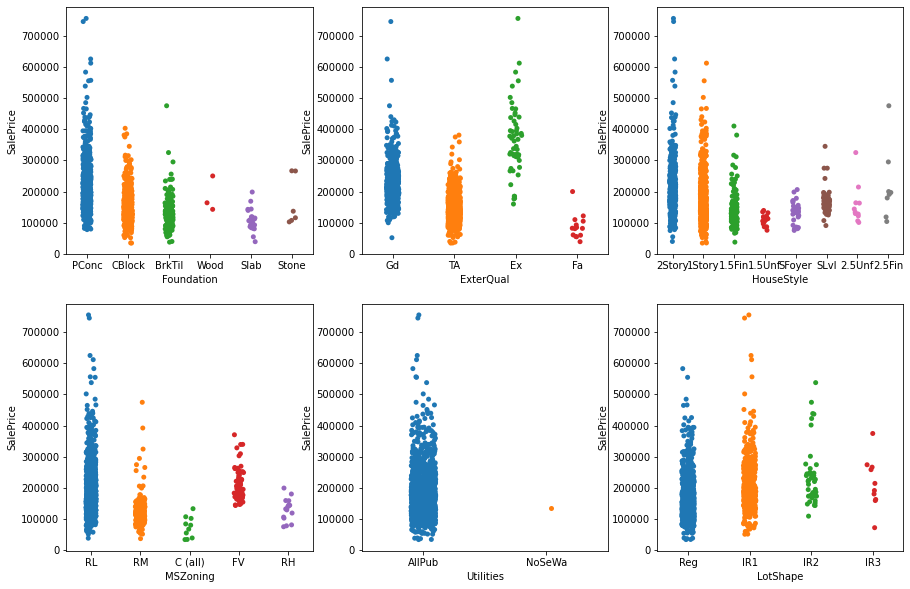

In [12]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(2,3,1)
sns.stripplot(data = train, x = 'Foundation', y = 'SalePrice', ax=ax1)

ax2 = fig.add_subplot(2,3,2)
sns.stripplot(data = train, x = 'ExterQual', y = 'SalePrice', ax=ax2)

ax3 = fig.add_subplot(2,3,3)
sns.stripplot(data = train, x = 'HouseStyle', y = 'SalePrice', ax=ax3)

ax4 = fig.add_subplot(2,3,4)
sns.stripplot(data = train, x = 'MSZoning', y = 'SalePrice', ax=ax4)

ax5 = fig.add_subplot(2,3,5)
sns.stripplot(data = train, x = 'Utilities', y = 'SalePrice', ax=ax5)

ax6 = fig.add_subplot(2,3,6)
sns.stripplot(data = train, x = 'LotShape', y = 'SalePrice', ax=ax6)

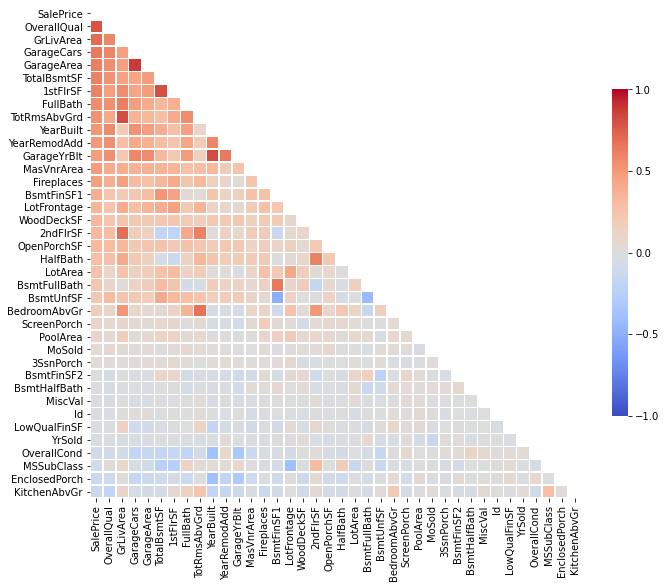

In [13]:
cor_houses = train.select_dtypes(exclude=['object'])

dependent = train['SalePrice']
corrdep = train.corrwith(dependent, axis = 0)
corrdep.sort_values()

xtest = corrdep.sort_values()
type(xtest)
order =[]
for x,z in xtest.items():
    order.append(x)
    
#reverse
order.reverse()

cor_houses2 = train.select_dtypes(exclude=['object'])
cor_houses2 = cor_houses.reindex(columns = order)
cor_houses2.head()
    
corr_matrix2 = cor_houses2.corr()



#mask
mask = np.zeros_like(corr_matrix2, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix2,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix2.columns, rotation = 0)
ax.set_xticklabels(corr_matrix2.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [14]:
corr2 = train.corr()
corr_pairs = corr2.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
print(sorted_pairs)

BsmtUnfSF      BsmtFinSF1     -0.495251
BsmtFinSF1     BsmtUnfSF      -0.495251
BsmtFullBath   BsmtUnfSF      -0.422900
BsmtUnfSF      BsmtFullBath   -0.422900
EnclosedPorch  YearBuilt      -0.387268
                                 ...   
KitchenAbvGr   KitchenAbvGr    1.000000
BedroomAbvGr   BedroomAbvGr    1.000000
HalfBath       HalfBath        1.000000
BsmtHalfBath   BsmtHalfBath    1.000000
SalePrice      SalePrice       1.000000
Length: 1444, dtype: float64


could be more beneficial to view the correlation coefficients in a list instead

In [15]:
#to view only strong pairs against our dependent variable
pos_strong_pairs = sorted_pairs[(abs(sorted_pairs) > 0.6)&(abs(sorted_pairs) !=1)]
print(pos_strong_pairs)

OverallQual   GarageCars      0.600671
GarageCars    OverallQual     0.600671
SalePrice     1stFlrSF        0.605852
1stFlrSF      SalePrice       0.605852
HalfBath      2ndFlrSF        0.609707
2ndFlrSF      HalfBath        0.609707
SalePrice     TotalBsmtSF     0.613581
TotalBsmtSF   SalePrice       0.613581
2ndFlrSF      TotRmsAbvGrd    0.616423
TotRmsAbvGrd  2ndFlrSF        0.616423
SalePrice     GarageArea      0.623431
GarageArea    SalePrice       0.623431
GrLivArea     FullBath        0.630012
FullBath      GrLivArea       0.630012
GarageCars    SalePrice       0.640409
SalePrice     GarageCars      0.640409
YearRemodAdd  GarageYrBlt     0.642277
GarageYrBlt   YearRemodAdd    0.642277
BsmtFullBath  BsmtFinSF1      0.649212
BsmtFinSF1    BsmtFullBath    0.649212
TotRmsAbvGrd  BedroomAbvGr    0.676620
BedroomAbvGr  TotRmsAbvGrd    0.676620
2ndFlrSF      GrLivArea       0.687501
GrLivArea     2ndFlrSF        0.687501
SalePrice     GrLivArea       0.708624
GrLivArea     SalePrice  

(array([  4.,  13.,  40., 226., 825., 731., 600., 342., 107.,  31.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

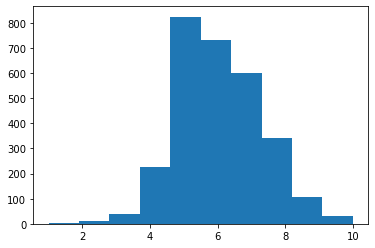

In [16]:
plt.hist(total_data['OverallQual'])
#The overall quality of the homes in the dataset have a normal distribution

## Data Cleaning

The plan now is to go through each feature one by one and decide how to fill in the blanks. Here I'm also able to determine if an entry in the column should take the median, mode, zero, or none. Also, the kaggle dataset describes some columns that state missing data are representative of a house not having that characteristic so we have to decide how we want to fill in these values. 

For this process I mainly used the describe and value_counts function. Here is one example below, the rest I will put in a loop for
what I determined is best and delete the exploratory code for cleanliness

In [17]:
total_data['FireplaceQu'].describe()

count     1499
unique       5
top         Gd
freq       744
Name: FireplaceQu, dtype: object

In [18]:
total_data['FireplaceQu'].value_counts()

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64

In [19]:
total_data["FireplaceQu"] = total_data["FireplaceQu"].fillna("None")

In [20]:
#determined median columns

x = total_data['LotFrontage'].median()
total_data['LotFrontage'] = total_data['LotFrontage'].fillna(x)


In [21]:
#determined none values

none_val = ['GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
           'BsmtFinType2','MasVnrType']
for col in none_val:
    total_data[col] = total_data[col].fillna('None')


In [22]:
#determined fill with zero

zero_col = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageArea','GarageCars',
           'BsmtFullBath','BsmtHalfBath']
for col in zero_col:
    total_data[col] = total_data[col].fillna(0)



In [23]:
#determined drop columns because of a high correlation coefficient with another variable in the dataset to reduce noise

total_data = total_data.drop('GarageYrBlt',axis=1)
total_data = total_data.drop('GarageArea',axis=1)

total_data.drop('Utilities',axis=1,inplace=True)
object_type = object_type.drop('Utilities')


In [24]:
#determined mode values


mode_col = ['Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Functional']

for col in mode_col:
    total_data[col] = total_data[col].fillna(total_data[col].mode()[0])


In [25]:
#check for null values

total_data.isnull().sum().sum()


0

## Feature Engineering

In [26]:
total_data['PoolArea'] = total_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
total_data['Fireplaces'] =  total_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
total_data['MiscVal'] =  total_data['MiscVal'].apply(lambda x: 1 if x > 0 else 0)


First let's transform some columns to true or false values represented by 1 or 0. These columns were determined to undergo
this transformation because the majority of their values fell into categories, so it would have been best to clean the data 
and get rid of some outliers by transforming these columns to binary attributes.

In [27]:
object_type = list(object_type) + ['MSSubClass']

for i in object_type:
    le = LabelEncoder()
    le.fit(total_data[i].unique())
    total_data[i] = le.transform(total_data[i])

Label encode the remainder of the non quantitative data

In [28]:
categorical_features = object_type + nominal

In [29]:
total_data['TotalSF'] = total_data['TotalBsmtSF']+ total_data['1stFlrSF'] + total_data['2ndFlrSF']

total_data['Exterior'] = total_data['Exterior1st'] + total_data['Exterior2nd']

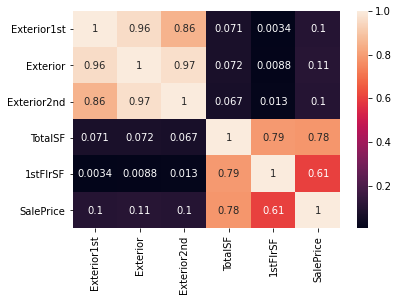

In [30]:
test_var_df = pd.DataFrame()
test_var_df['Exterior1st']=total_data['Exterior1st']
test_var_df['Exterior']=total_data['Exterior']
test_var_df['Exterior2nd'] = total_data['Exterior2nd']
test_var_df['TotalSF'] = total_data['TotalSF']
test_var_df['1stFlrSF'] = total_data['1stFlrSF']
test_var_df['SalePrice'] = y

test_var_corr = test_var_df.corr()
sns.heatmap(test_var_corr, annot=True)
plt.show()

In [31]:
total_data.drop(['1stFlrSF'],axis=1,inplace=True)
total_data.drop(['Exterior1st','Exterior2nd'],axis=1,inplace=True)


In [32]:
categorical_features.append('Exterior')
categorical_features.remove('Exterior1st')
categorical_features.remove('Exterior2nd')

The above was for feature creation and testing to help decide which columns presented multicolinearity and which columns
should be dropped to reduce the noise of our model

In [33]:
def calc_vif(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)



In [34]:
#test to see what columns decide the overall quality of a home
vif_testdf = total_data[['SaleCondition',
                         'OverallQual']]

xtest = calc_vif(vif_testdf)
xtest


,variables,VIF
0,SaleCondition,10.355283
1,OverallQual,10.355283


I wanted to test for VIF across all variables, then I realized that this is high dimensional data and running a VIF test against all the columns wouldn't be wise.

But given that OverallQual was a highly correlated factor in predicting SalePrice, I wondered if there was specific columns directly related to the OverallQual scoring. What I found were that the majority of columns had a high VIF value with OverallQual. The following columns were the few that did not have a high VIF against OverallQual: Lotshape, Lotconfig,
LandSlope, Neighborhood, Condition1, BldgType, RoofStyle, MasVnrArea, BsmtQual, BsmtExposure, BsmtFinType1,BsmtFinSF1, BsmtFinSF2, HeatingQC, LowQualFinSF, BsmtFullBath, BsmtHalfBath, HalfBath, Fireplaces, GarageType, GarageFinish,
WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

Most notably, none of the Porch related columns had a high VIF with OverallQual. So, if you lived in this area and were thinking about revamping your porch to sell your house, the money could better be invested elsewhere.

## More Data Cleaning 

Data clean some outliers for variables that have a high correlation or the most weight in the algorithm

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

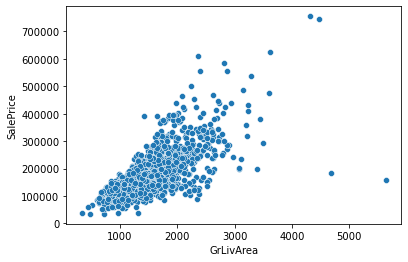

In [35]:
sns.scatterplot(x = total_data.GrLivArea,y=train.SalePrice)

In [36]:
total_data.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index,inplace=True)
y.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index,inplace=True)

Log transform our dependent variable because of the skewness we saw earlier

In [37]:
y = np.log(y)

C:\Users\19046\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

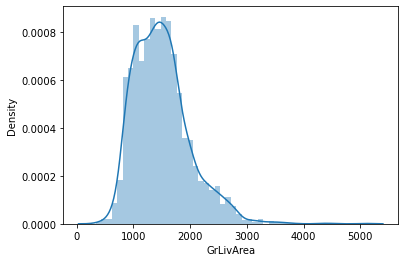

In [38]:
sns.distplot(total_data['GrLivArea'])


We still have some skewness in this variable so we can log transform it also

In [39]:
total_data['GrLivArea'] = np.log(total_data['GrLivArea'])


In [40]:
#same issue with TotalBsmtSF
total_data.loc[total_data['TotalBsmtSF']>0,'TotalBsmtSF'] = np.log(total_data.loc[total_data['TotalBsmtSF']>0,'TotalBsmtSF'])

In [41]:
numerical_features = total_data.drop(categorical_features,axis=1).columns

lets view the skewness for our numerical features

In [42]:
skew = total_data[numerical_features].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skewness': skew})
skewness

,skewness
PoolArea,15.494756
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
MiscVal,5.035573
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
MasVnrArea,2.621719
OpenPorchSF,2.529358


We have some heavy skewness on some our variables, to normalize this data we can do a boxcox transformation

In [43]:
skew_col = skewness[skewness['skewness'] > 0.5].index

for col in skew_col :
    total_data[col] = boxcox1p(total_data[col],0.15)

Finally split up the training and evaluation dataset

In [44]:
x_train = total_data[:-len(test)]
x_test = total_data[-len(test):]

In [45]:
print(x_train.shape)
print(x_test.shape)

(1458, 71)
(1459, 71)


## Model Testing

For the models below, I tested scaling my data with the RobustScaler, MinMaxScaler, and StandardScaler. In the end the RobustScaler decreased my RMSE score the most, so I only left this one in the code for cleanliness.

First to find the most optimal value for alpha in our regression testing we should run a gridsearch. The below only shows the gridsearch for ElasticNet, but I tested it out on Lasso and Ridge too.

In [46]:
param_grid = {'alpha' : [0.00005,0.0005,0.007,0.1,0.00009, 5 ,10], 'max_iter':[1000,2000,1500,2500]}
grid = GridSearchCV(ElasticNet(),param_grid=param_grid,scoring='neg_mean_squared_error')
grid.fit(x_train,y)
grid.best_params_

{'alpha': 0.0005, 'max_iter': 1000}

Ridge Regresssion testing

In [47]:
ridge = make_pipeline(RobustScaler(),Ridge(alpha=10))
score = cross_validate(ridge,x_train,y,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

ridge_train_score = np.sqrt(-score['train_score'].mean())
ridge_test_score = np.sqrt(-score['test_score'].mean())

print(f'Ridge Regression RMSE train data set score {ridge_train_score}')
print(f'Ridge Regression RMSE test data set score {ridge_test_score}')


Ridge Regression RMSE train data set score 0.11120636270708113
Ridge Regression RMSE test data set score 0.11947920550955274


ElasticNet testing

In [48]:
elastic = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005))
score2 = cross_validate(elastic,x_train,y,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

elastic_train_score = np.sqrt(-score2['train_score'].mean())
elastic_test_score = np.sqrt(-score2['test_score'].mean())

print(f'ElasticNet RMSE train data set score {elastic_train_score}')
print(f'ElasticNet RMSE test data set score {elastic_test_score}')


ElasticNet RMSE train data set score 0.11084353744520516
ElasticNet RMSE test data set score 0.11926618980794246


Lasso Regression testing

In [49]:
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.000000005))
score3 = cross_validate(lasso,x_train,y,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

lasso_train_score = np.sqrt(-score3['train_score'].mean())
lasso_test_score = np.sqrt(-score3['test_score'].mean())

print(f'ElasticNet RMSE train data set score {lasso_train_score}')
print(f'ElasticNet RMSE test data set score {lasso_test_score}')

ElasticNet RMSE train data set score 0.11053184102504203
ElasticNet RMSE test data set score 0.12018486482143566


Support Vector Machine testing

In [50]:
svm = SVR()

svm = make_pipeline(RobustScaler(),SVR())
score4 = cross_validate(svm,x_train,y,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

svm_train_score = np.sqrt(-score4['train_score'].mean())
svm_test_score = np.sqrt(-score4['test_score'].mean())

print(f'SVM RMSE train data set score {svm_train_score}')
print(f'SVM RMSE test data set score {svm_test_score}')



SVM RMSE train data set score 0.0820222740210476
SVM RMSE test data set score 0.15316112117851813


These RMSE scores are telling that I overfit the data. I tried to prevent this by going back and conducting a PCA analysis. Although, my scores didn't approve. My attempt can be found below in the last section of code.

Overall the scores are very similar, let's train our models and look at the prediction

In [51]:
ridge.fit(x_train,y)
ridge_pred = ridge.predict(x_test)

elastic.fit(x_train,y)
elastic_pred = elastic.predict(x_test)


in order to reverse the logarithmic transformation we can use expm1()

In [52]:
print('Ridge prediction describe\n\n',
    pd.Series(np.expm1(ridge_pred)).describe(),'\n',
     '\nElastic prediction describe\n\n',
     pd.Series(np.expm1(elastic_pred)).describe())


Ridge prediction describe

 count      1459.000000
mean     178538.392105
std       76783.408938
min       47994.535622
25%      126497.982841
50%      159404.856255
75%      211155.736343
max      927465.385982
dtype: float64 
 
Elastic prediction describe

 count      1459.000000
mean     178548.042774
std       76956.544576
min       47918.957809
25%      126840.720877
50%      159520.742631
75%      210832.651508
max      937652.123232
dtype: float64


For a better score we can average the predictions together. I tested a few different predictions and submitted them to Kaggle
The best score was the combination prediction below

In [53]:
y_pred = 0.5*np.expm1(elastic_pred) + 0.5*np.expm1(ridge_pred)

fin_submission = pd.DataFrame()
fin_submission['Id'] = test['Id']
fin_submission['SalePrice'] = y_pred
# fin_submission.to_csv('submission10.csv',index=False)